# Modelo de clasificación de cancer maligno.

## Origen de los datoss.

---
* Para el modelo de clasificación de tipos de cáncer maligno hemos obtenido las imágenes del siguiente dataset de Kaggle:

    - Enlace: https://www.kaggle.com/datasets/riyaelizashaju/isic-skin-disease-image-dataset-labelled

* De este dataset hemos utilizado las carpetas que son consideradas malignas como Melanoma, Basall Cell Carcinoma y Squamous Cell Carcinoma (Melanomas y Carcinomas, los tipos de cáncer de piel más comunes).

## Instalación de recursos e importación de librerías

---

* Realizamos todas las instalaciones necesarias para la elaboración de nuestros modelos.

In [2]:
pip install imblearn==0.0

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [29]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import zipfile
import keras
import scipy
import os
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

from PIL import Image
from collections import Counter
from tensorflow.python.client import device_lib
from efficientnet.tfkeras import EfficientNetB0, preprocess_input

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, VGG19, NASNetLarge, NASNetMobile, Xception

from keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import load_model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, Callback
from keras.applications import InceptionV3

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

%matplotlib inline

## Extracción de los datos

---

* Procedemos a la extraccíón de los datos:

  * Especificamos la ruta del origen de los datos y la ruta del destino donde los datos son extraidos y descomprimidos.
  * Listamos las carpetas extraidas y las imprimimos.
  * Creamos la variable `train_dir` que contiene las carpetas con las imágenes correspondientes a las dos clases principales con las que vamos a trabajar nuestros modelos: `basal_cell_carcinoma`, `melanoma` y `squamous_cell_carcinoma`.

In [24]:
# Ruta del archivo ZIP en Google Drive
ruta_archivo_zip = 'C:/Users/admin2/Desktop/dermascan_colabs/zips/clasificador_de_malignos.zip'

# Ruta donde deseas extraer los archivos
ruta_destino = 'C:/Users/admin2/Desktop/dermascan_colabs/unzips/'

# Descomprime el contenido del ZIP
with zipfile.ZipFile(ruta_archivo_zip, 'r') as zip_ref:
    zip_ref.extractall(ruta_destino)

# Lista los archivos extraídos
archivos_extraidos = os.listdir(ruta_destino)
print(f'Archivos extraídos: {archivos_extraidos}')

# Ruta de la carpeta que contiene las imágenes
train_dir = os.path.join(ruta_destino, 'clasificador_de_malignos')


# Verifica la existencia de la carpeta antes de listar los archivos
if os.path.exists(train_dir):
    archivos_en_carpeta = os.listdir(train_dir)
    print(f'Archivos en la carpeta: {archivos_en_carpeta}')
else:
    print(f'La carpeta {train_dir} no existe.')


# Lista de nombres de archivos en la carpeta
clasificador = os.listdir(train_dir)

Archivos extraídos: ['cancer_y_otros', 'clasificador_de_malignos', 'objeto_o_piel', 'sana_vs_cancer']
Archivos en la carpeta: ['basal_cell_carcinoma', 'melanoma', 'squamous_cell_carcinoma']


## Muestreo y Visualización de los datos

---

### Contenido del dataset

In [3]:
# Number of images for each disease
nums_train = {}
nums_val = {}
for s in clasificador:
    nums_train[s] = len(os.listdir(train_dir + '/' + s))
img_per_class_train = pd.DataFrame(nums_train.values(), index=nums_train.keys(), columns=["no. of images"])
print('Train data distribution :')
img_per_class_train

Train data distribution :


no. of images
basal_cell_carcinoma              3323
melanoma                          4522
squamous_cell_carcinoma            628

<Axes: title={'center': 'Distribución de los datos'}, xlabel='Tipo de cáncer de piel', ylabel='Número de imágenes'>

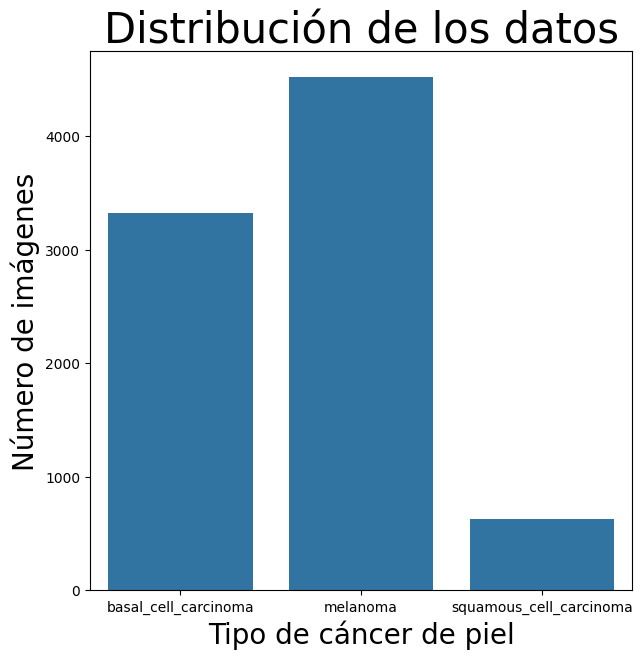

In [4]:
plt.figure(figsize=(7,7))
plt.title('Distribución de los datos',fontsize=30)
plt.ylabel('Número de imágenes',fontsize=20)
plt.xlabel('Tipo de cáncer de piel',fontsize=20)

keys = list(nums_train.keys())
vals = list(nums_train.values())
sns.barplot(x=keys, y=vals)

Podemos ver que basal cell carcinoma y melanoma si estan equilibradas pero squamous cell carcinoma tiene muy pocas imagenes.

### Visualización

* Función para visualizar los datos

In [6]:
# Function to show image
train = ImageFolder(train_dir, transform=transforms.ToTensor())
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    return image.permute(1, 2, 0)

#### Muestra de imágenes de cáncer de piel tipo **Basal Cell Carcinoma**

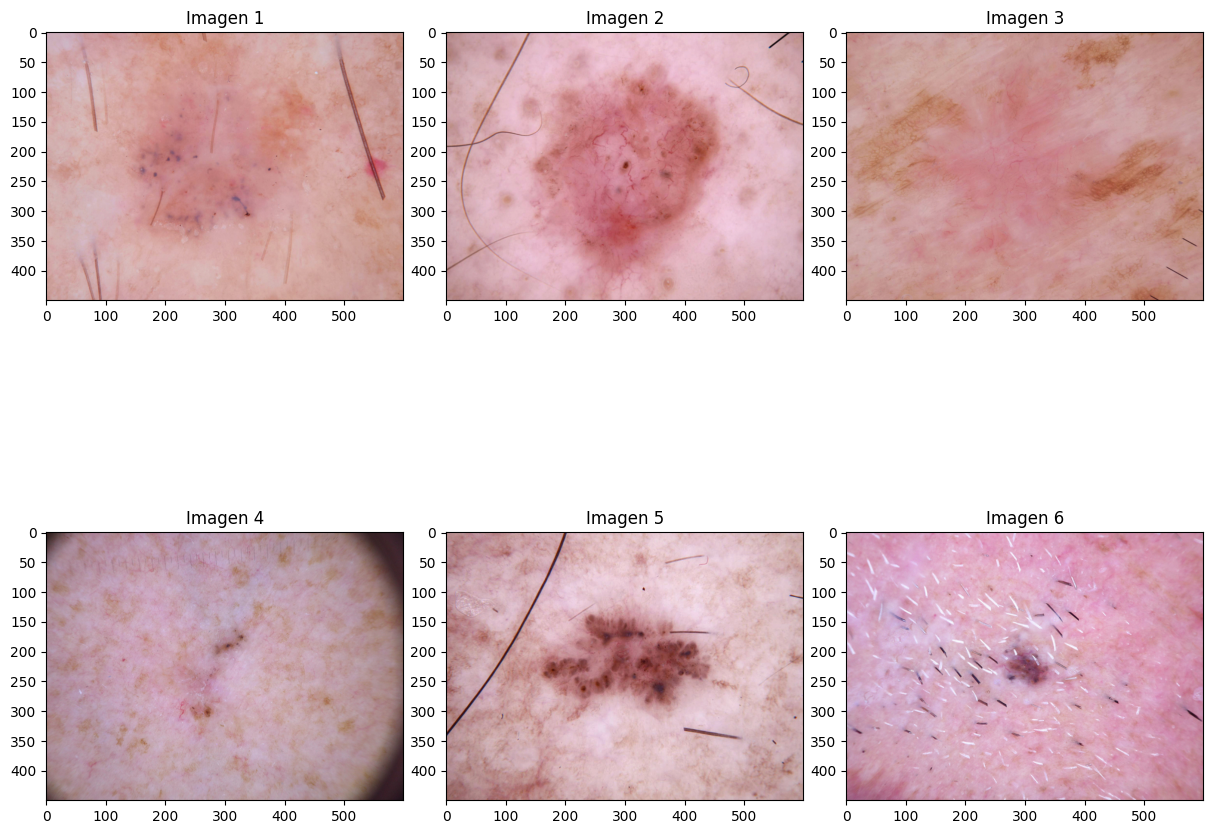

In [28]:
# Directorio que contiene las imágenes
basal_cell_carcinoma_dir = os.path.join(train_dir, "basal_cell_carcinoma")

# Muestra 6 imágenes
fig, axs = plt.subplots(2, 3, figsize=(12, 10))
fig.tight_layout(pad=0)

# Iterar sobre las primeras 6 imágenes del directorio
for i in range(6):
    image_files = [file for file in os.listdir(basal_cell_carcinoma_dir) if file.endswith('.jpg')]
    if i < len(image_files):
        image_path = os.path.join(basal_cell_carcinoma_dir, image_files[i])
        image = Image.open(image_path)
        axs[i//3, i%3].imshow(image)
        axs[i//3, i%3].set_title(f'Imagen {i+1}')
    else:
        axs[i//3, i%3].axis('off')  # No mostrar ejes si no hay imagen para mostrar

plt.show()

#### Muestra de imágenes de cáncer de piel tipo **Melanoma**

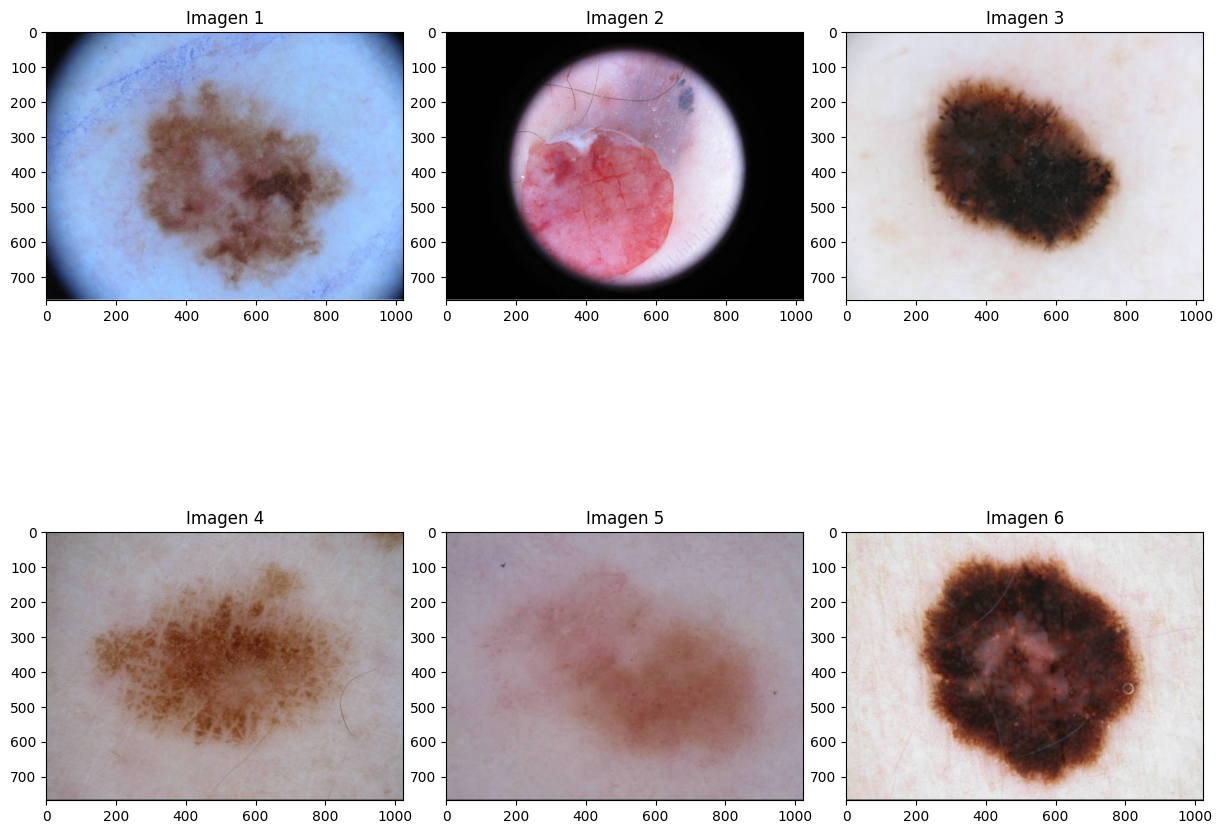

In [26]:
# Asegúrate de que el directorio "melanoma" esté dentro del directorio principal
melanoma_dir = os.path.join(train_dir, "melanoma")

# Muestra 6 imágenes
fig, axs = plt.subplots(2, 3, figsize=(12, 10))
fig.tight_layout(pad=0)

# Iterar sobre las primeras 6 imágenes del directorio
for i in range(6):
    image_files = [file for file in os.listdir(melanoma_dir) if file.endswith('.jpg')]
    if i < len(image_files):
        image_path = os.path.join(melanoma_dir, image_files[i])
        image = Image.open(image_path)
        axs[i//3, i%3].imshow(image)
        axs[i//3, i%3].set_title(f'Imagen {i+1}')
    else:
        axs[i//3, i%3].axis('off')  # No mostrar ejes si no hay imagen para mostrar

plt.show()

#### Muestra de imágenes de cáncer de piel tipo **Squamous cell carcinoma**



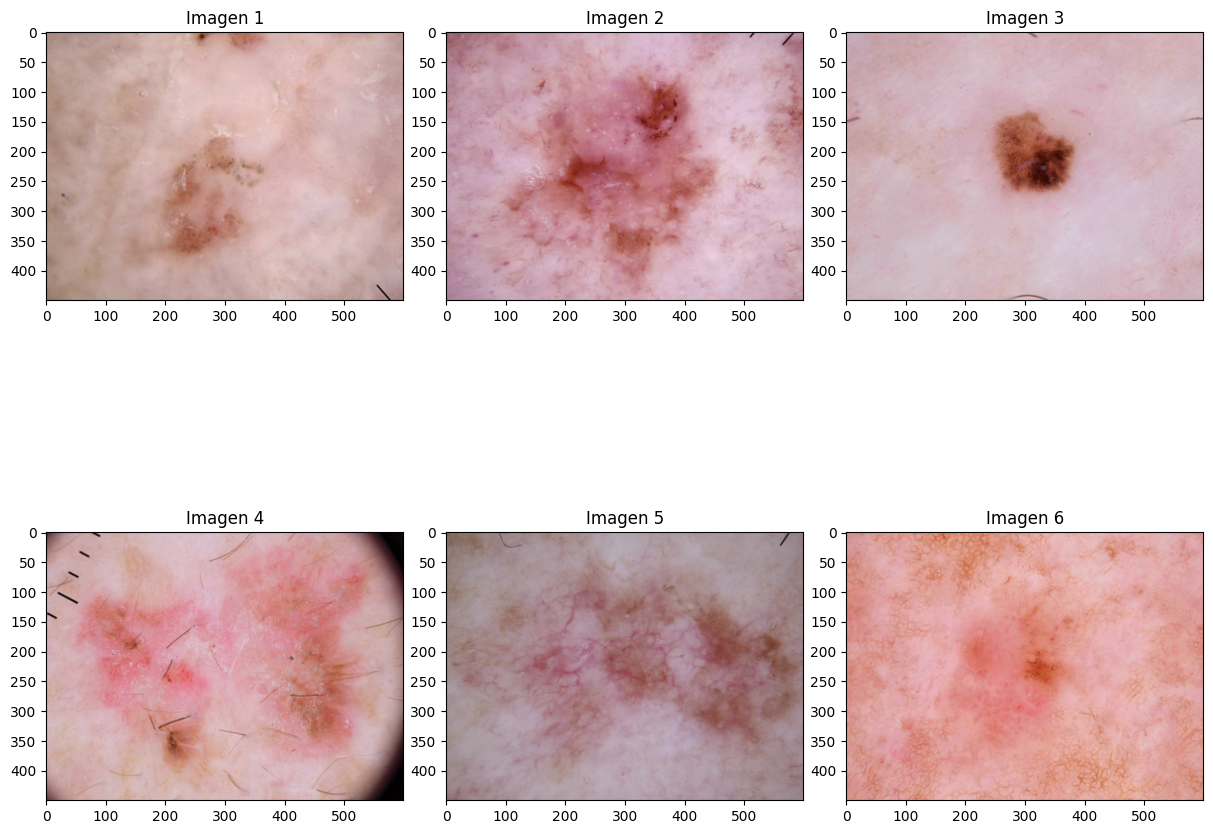

In [27]:
# Asegúrate de que el directorio "melanoma" esté dentro del directorio principal
squamous_cell_carcinoma_dir = os.path.join(train_dir, "squamous_cell_carcinoma")

# Muestra 6 imágenes
fig, axs = plt.subplots(2, 3, figsize=(12, 10))
fig.tight_layout(pad=0)

# Iterar sobre las primeras 6 imágenes del directorio
for i in range(6):
    image_files = [file for file in os.listdir(squamous_cell_carcinoma_dir) if file.endswith('.jpg')]
    if i < len(image_files):
        image_path = os.path.join(squamous_cell_carcinoma_dir, image_files[i])
        image = Image.open(image_path)
        axs[i//3, i%3].imshow(image)
        axs[i//3, i%3].set_title(f'Imagen {i+1}')
    else:
        axs[i//3, i%3].axis('off')  # No mostrar ejes si no hay imagen para mostrar

plt.show()

## Preparación y tratamiento de datos

### Trasformación: redimensionado de imágenes

---

En este bloque de código, realizamos el proceso de transformación de nuestros datos aplicando un redimensionado de las imágenes que van a ser utilizadas en nuestros modelos posteriormente.


* Creamos la función `redimensionar_imagen`:

  * Esta función toma como entrada la ruta de una imagen y el nuevo tamaño deseado. Luego, abre la imagen, la redimensiona al nuevo tamaño especificado y la convierte en un array.

* El *tamaño* deseado para todas las imágenes se define como (150, 150).

* Redimensionamiento de las imágenes de entrenamiento: tanto para la clase "basal_cell_carcinoma" como para la clase "melanoma", asi como para "squamous_cell_carcinoma" utilizamos la función *redimensionar_imagen*.

* Nos aseguramos que todas las imágenes tengan el mismo tamaño:

  * Realizamos una comprobación con un blucle `for` para asegurarnos de que todas las imágenes tengan el tamaño correcto (150, 150, 3).

* Se concatenan los datos de ambas clases (piel y objeto) en un solo conjunto de datos.

* Creamos las etiquetas correspondientes:
  * Las imágenes de la clase "cancer" se etiquetan como 0.
  * Las imágenes de la clase "otras_lesiones" se etiquetan como 1.

In [29]:
def redimensionar_imagen(ruta, nuevo_tamano):
    imagen = Image.open(ruta)
    imagen_redimensionada = imagen.resize(nuevo_tamano)
    arreglo_pixeles_redimensionado = np.array(imagen_redimensionada)
    return arreglo_pixeles_redimensionado

# Definir el nuevo tamaño deseado
tamano=150
nuevo_tamano = (tamano, tamano)


# Redimensionar las imágenes de entrenamiento Basal cell carcinoma
datos_train_bcb_redimensionados = [redimensionar_imagen(os.path.join(train_dir, 'basal_cell_carcinoma', nombre_imagen), nuevo_tamano) for nombre_imagen in os.listdir(os.path.join(train_dir, 'basal_cell_carcinoma'))]
# Redimensionar las imágenes de entrenamiento Melanoma
datos_train_m_redimensionados = [redimensionar_imagen(os.path.join(train_dir, 'melanoma', nombre_imagen), nuevo_tamano) for nombre_imagen in os.listdir(os.path.join(train_dir, 'melanoma'))]
# Redimensionar las imágenes de entrenamiento Squamous cell carcinoma
datos_train_scc_redimensionados = [redimensionar_imagen(os.path.join(train_dir, 'squamous_cell_carcinoma', nombre_imagen), nuevo_tamano) for nombre_imagen in os.listdir(os.path.join(train_dir, 'squamous_cell_carcinoma'))]

# Asegurarse de que todas las imágenes tengan el mismo tamaño
datos_train_bcb_redimensionados = np.array([img for img in datos_train_bcb_redimensionados if img.shape == (tamano, tamano, 3)])
datos_train_m_redimensionados = np.array([img for img in datos_train_m_redimensionados if img.shape == (tamano, tamano, 3)])
datos_train_scc_redimensionados = np.array([img for img in datos_train_scc_redimensionados if img.shape == (tamano, tamano, 3)])

# Concatenar los datos de ambas clases
datos_train_redimensionados = np.concatenate([
                                              datos_train_bcb_redimensionados,
                                              datos_train_m_redimensionados,
                                              datos_train_scc_redimensionados], axis=0)

# Crear etiquetas correspondientes para cada clase
etiquetas_train_bcb = np.zeros(len(datos_train_bcb_redimensionados))
etiquetas_train_m = np.ones(len(datos_train_m_redimensionados), )
etiquetas_train_scc = np.full(len(datos_train_scc_redimensionados), 2)

# Concatenar las etiquetas de todas las clases
etiquetas_train_redimensionadas = np.concatenate([
                                                  etiquetas_train_bcb,
                                                  etiquetas_train_m,
                                                  etiquetas_train_scc], axis=0)



* Este proceso es esencial para preparar los datos de las imágenes antes de alimentar a un modelo de ML para su entrenamiento.

* El proceso de redimensionado asegura que todas las imágenes tengan el mismo tamaño, lo que facilita el procesamiento por parte del modelo.

* La creación de etiquetas tambíen es crucial para el entrenamiento supervisado del modelo, ya que le proporciona la información necesaria sobre las clases a predecir.

### Data splitting: Conjunto de entrenamiento y test

---

Este fragmento de código se encarga de preparar los datos  y dividirlos en conjuntos de entrenamiento y test, tambíen realiza una normalización de los píxeles de las imágenes y convierte las etiquetas en formato one-hot encoding.

* **División de los datos en conjuntos de entrenamiento y test**:
  * Se utiliza la función `train_test_split` de *scikit-learn* para dividir los datos de imágenes (datos_train_redimensionados) y etiquetas (etiquetas_train_redimensionadas) en dos conjuntos separados: uno para entrenamiento (`X_train, y_train`) y otro para prueba (`X_test, y_test`).
  * Con el parámetro `test_size=0.2` indicamos que el 20% de los datos se utilizarán para el conjunto de prueba, mientras que el 80% se utilizará para el conjunto de entrenamiento.
  * Con el parámetro `random_state=42` aseguramos la reproducibilidad al fijar la semilla aleatoria.
    

* **Normalización de los píxeles:** las intensidades de los píxeles de las imágenes se normalizan dividiendo cada valor de píxel por 255.
  * Este proceso asegura que todas las características estén en una escala similar, lo que puede mejorar la convergencia del modelo durante el entrenamiento. Las imágenes se convierten a tipo de datos float32 antes de la normalización para permitir la división por un número decimal.

* **Conversión de etiquetas a formato one-hot**:
  * Las etiquetas (*y_train / y_test*) se convierten en formato one-hot utilizando la función `to_categorical` de Keras.
  * Esto consiste en  que cada etiqueta se representa como un vector binario donde un único valor es 1 y el resto son 0. Por ejemplo, si hay tres clases (como en este caso), la clase 0 se representará como [1, 0, 0], la clase 1 como [0, 1, 0] y la clase 2 como [0, 0, 1].
  * Es útil ya que proporciona una representación más adecuada de las etiquetas para el modelo de aprendizaje automático.

In [32]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(datos_train_redimensionados, etiquetas_train_redimensionadas, test_size=0.2, random_state=42)

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

y_train_one_hot = to_categorical(y_train, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

## Creación de los Modelos ML

---

### Tasa de aprendizaje dinámica y personalizada

---

Como novedad con respecto a otros modelos anteriores hemos introducido una nueva funcionalidad a nuestro modelo de ML, una tasa dinámica de LearningRate.  

Para ello, hemos creado una clase `CustomLearningRateScheduler` que se utiliza como un *callback* personalizado en Keras/TensorFlow para ajustar dinámicamente la tasa de aprendizaje durante el entrenamiento de un modelo de redes neuronales. 

Esta clase se activa en cada época y se encarga de monitorear el `val_accuracy`.

* **Objetivo**:
  * El objetivo principal de esta clase es mejorar el rendimiento del modelo ajustando la tasa de aprendizaje de manera dinámica.

* **Parámetros**:
  * `factor`: Factor de reducción de la tasa de aprendizaje cuando se activa el ajuste. En este caso, se divide el learning rate actual por 2.
  * `patience`: Número de épocas a esperar antes de reducir la tasa de aprendizaje. Aquí se ha especificado una paciencia de 1 época.
  * `min_lr`: Tasa de aprendizaje mínima permitida, en este caso, 1e-7.

* **Funcionamiento**:
  * Durante el entrenamiento del modelo, en cada época, se verifica el `val_accuracy`. 
  * Si el `val_accuracy` disminuye con respecto a la mejor precisión anterior, se activa el mecanismo para reducir la tasa de aprendizaje. Esto se controla mediante la variable de `patience`.
  * Cuando se activa el ajuste, el learning rate actual se reduce multiplicándolo por `factor`, asegurándose de que no sea menor que `min_lr`.
  * Se muestra un mensaje indicando la reducción de la tasa de aprendizaje para informar al usuario sobre el cambio en la configuración del modelo.

* **Checkpoint**:
  * Además del ajuste dinámico de la tasa de aprendizaje, se menciona un checkpoint que guarda el modelo cada vez que mejora el `val_accuracy`. Esto es útil para evitar perder el progreso del modelo en caso de interrupciones o detenciones prematuras del entrenamiento.

In [33]:
class CustomLearningRateScheduler(Callback):
    def __init__(self, factor=0.5, patience=1, min_lr=1e-7):
        super(CustomLearningRateScheduler, self).__init__()
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.best_val_accuracy = float('-inf')
        self.wait = 0
        self.current_lr = None

    def on_epoch_begin(self, epoch, logs=None):
        if self.current_lr is None:
            self.current_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy', 0)

        if val_accuracy > self.best_val_accuracy:
            self.best_val_accuracy = val_accuracy
            self.wait = 0
            # Guardar el modelo cuando la precisión en el conjunto de validación mejora
        else:
            self.wait += 1
            if self.wait >= self.patience:
                new_lr = max(self.current_lr * self.factor, self.min_lr)
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
                self.current_lr = new_lr  # Actualizar el valor actual de la tasa de aprendizaje
                print(f'Reverting learning rate to {new_lr}')
                self.wait = 0


### Aumento de Datos para Entrenamiento y Prueba

---

En este modelo tambíen hemos aplicado (como en otros) técnicas de aumento de datos tanto para el conjunto de entrenamiento como para el conjunto de prueba.

El aumento de datos es una técnica comúnmente utilizada en el aprendizaje automático para mejorar el rendimiento del modelo mediante la generación de variaciones de las imágenes originales.

* **Generadores de Imágenes**:
  * Creamos dos instancias de `ImageDataGenerator`: `datagen_train` para el conjunto de entrenamiento y `datagen_test` para el conjunto de prueba.
  * Especificamos varios parámetros de aumento de datos, como rango de rotación, desplazamiento, cizallamiento, zoom y volteo horizontal.
  * `datagen_train.fit(X_train)` y `datagen_test.fit(X_test)` se utilizan para calcular estadísticas sobre los conjuntos de datos de entrenamiento y prueba respectivamente, y configurar internamente los generadores de datos para aplicar el aumento de datos durante el entrenamiento y la evaluación del modelo.

* **Codificación One-Hot**:
  * Convertimos las etiquetas de las clases a codificación one-hot utilizando la función `to_categorical` de Keras. Esto es necesario para que el modelo pueda interpretar las etiquetas como vectores de probabilidad.

* **Generadores de Imágenes Aumentadas**:
  * Creamos generadores de imágenes aumentadas para el conjunto de entrenamiento y el conjunto de prueba utilizando los métodos `flow` de los objetos `ImageDataGenerator`.
  * Especificamos un tamaño de lote de 32 para ambos generadores.

* **Pesos de Clase**:
  * Calculamos los pesos de clase utilizando la técnica de ponderación de clases. Los pesos de clase se utilizan para abordar el desequilibrio de clases en el conjunto de datos, dando más peso a las clases subrepresentadas y menos peso a las clases sobrerepresentadas.
  * Utilizamos la función `Counter` de la librería `collections` para calcular las frecuencias de cada clase en el conjunto de entrenamiento.
  * Los pesos de clase se calculan como la inversa de la proporción de ejemplos de cada clase en el conjunto de entrenamiento, normalizados por el número total de clases y el número total de ejemplos.

In [35]:
# Aumento de datos para el conjunto de entrenamiento y prueba
datagen_train = ImageDataGenerator(
    rotation_range=60,
    width_shift_range=0.35,
    height_shift_range=0.35,
    shear_range=0.35,
    zoom_range=0.35,
    horizontal_flip=True,
    fill_mode='nearest'
)


datagen_test = ImageDataGenerator()

datagen_train.fit(X_train)
datagen_test.fit(X_test)


# Generador de imágenes aumentadas para el conjunto de entrenamiento
train_generator = datagen_train.flow(X_train, y_train_one_hot, batch_size=32)

# Generador de imágenes para el conjunto de prueba
test_generator = datagen_test.flow(X_test, y_test_one_hot, batch_size=32)


### Modelo: Xception (pre-trained model)

---

* Resumen del `best_model8`(Checkpoint del mejor valor de precisión alcanzado durante el erntrenamiento)
  
```
Número de aciertos: 1601
Número de fallos: 94
Accuracy: 0.9445427728613569
```9720

#### Entrenamiento del Modelo Utilizando Xception

En esta ocasión hemos entrenado nuestro modelo utilizando la arquitectura de red neuronal *Xception* pre-entrenada como base. *Xception* es una red neuronal convolucional profunda que ha sido pre-entrenada en el conjunto de datos de *ImageNet* y es conocida por su rendimiento en tareas de clasificación de imágenes.

* **Base del Modelo**:
  * Utilizamos `Xception` como base del modelo. Al especificar `include_top=False`, omitimos la capa densa de salida de ImageNet y definimos el tamaño de entrada de las imágenes como (150, 150, 3), con la variable donde tenemos esos valores: tamano.
  * Especificamos `pooling='max'` para utilizar la capa de agrupación máxima al final del modelo, lo que reduce la dimensionalidad de las características extraídas.

* **Callbacks**:
  * Creamos dos callbacks: `CustomLearningRateScheduler` y `ModelCheckpoint`.
    - `CustomLearningRateScheduler`: Ajusta dinámicamente la tasa de aprendizaje durante el entrenamiento del modelo. Reduce la tasa de aprendizaje a la mitad si la precisión en el conjunto de validación no mejora después de 2 épocas.
    - `ModelCheckpoint`: Guarda el modelo con la mejor precisión en el conjunto de validación durante el entrenamiento.

* **Capas Personalizadas**:
  * Agregamos capas personalizadas en la parte superior de la base del modelo. 
    - Agregamos una capa densa con 1024 unidades y activación ReLU, seguida de una capa de dropout con una tasa de 0.5 para evitar el sobreajuste.
    - La última capa densa tiene 3 neuronas de salida y utiliza una activación softmax para la clasificación de tres clases.

* **Capas Entrenables**:
  * Marcamos las últimas 10 capas del modelo base como entrenables. Esto nos permite ajustar estas capas a nuestro conjunto de datos específico durante el entrenamiento.

* **Compilación del Modelo**:
  * Compilamos el modelo utilizando el optimizador Adam con una tasa de aprendizaje de 0.0005, la función de pérdida `categorical_crossentropy` y la métrica de `accuracy`.

* **Entrenamiento del Modelo**:
  * Entrenamos el modelo utilizando los generadores de datos aumentados para el conjunto de entrenamiento y el conjunto de prueba.
  * Especificamos un total de 20 épocas de entrenamiento y utilizamos los callbacks `CustomLearningRateScheduler` y `ModelCheckpoint` durante el proceso de entrenamiento.

In [37]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(tamano, tamano, 3), pooling='max')

# Crear el callback CustomLearningRateScheduler
custom_lr_scheduler = CustomLearningRateScheduler(factor=0.5, patience=2, min_lr=1e-12)

# PARA LOCAL: cambia la ruta al directorio local donde deseas guardar el archivo .h5
nombre_archivo = 'best_model_checkpoint8.h5'
ruta_guardado_local = 'C:/Users/admin2/Desktop/dermascan_colabs/modelos/' + nombre_archivo

# Callback para guardar el modelo con la mejor precisión en el conjunto de validación
model_checkpoint = ModelCheckpoint(ruta_guardado_local, save_best_only=True, monitor='val_accuracy', mode='max')

# Agregar capas personalizadas
x = base_model.output
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

# Crear el modelo
model8 = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers[-10:]:
    layer.trainable = True

# Compilar el modelo con el optimizador Adam y el callback ReduceLROnPlateau
model8.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Mostrar resumen del modelo
model8.summary()

# Entrenar el modelo utilizando el generador de datos aumentados para el conjunto de entrenamiento
history=model8.fit(train_generator, validation_data=test_generator, epochs=20, callbacks=[custom_lr_scheduler, model_checkpoint])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 74, 74, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                            

* Parece ser que este modelo tiene cierto margen de mejora asi que le vamos a añadir 20 epocas más para que continue el entrenamiento por el chekpoint del valor con mayor precisión.

In [38]:
# Continuar entrenando el modelo por más épocas
history_continued1 = model8.fit(train_generator, validation_data=test_generator, epochs=20, callbacks=[custom_lr_scheduler, model_checkpoint])

Epoch 1/20
212/212 [==============================] - 30s 138ms/step - loss: 0.0932 - accuracy: 0.9671 - val_loss: 0.2411 - val_accuracy: 0.9345
Epoch 2/20
212/212 [==============================] - 30s 140ms/step - loss: 0.0902 - accuracy: 0.9684 - val_loss: 0.2496 - val_accuracy: 0.9369
Epoch 3/20
212/212 [==============================] - 28s 131ms/step - loss: 0.0902 - accuracy: 0.9675 - val_loss: 0.2366 - val_accuracy: 0.9322
Epoch 4/20
212/212 [==============================] - 30s 140ms/step - loss: 0.0877 - accuracy: 0.9684 - val_loss: 0.2406 - val_accuracy: 0.9386
Epoch 5/20
212/212 [==============================] - 28s 132ms/step - loss: 0.0773 - accuracy: 0.9709 - val_loss: 0.2912 - val_accuracy: 0.9286
Epoch 6/20
212/212 [==============================] - 28s 129ms/step - loss: 0.0787 - accuracy: 0.9724 - val_loss: 0.2700 - val_accuracy: 0.9280
Epoch 7/20
212/212 [==============================] - 29s 135ms/step - loss: 0.0645 - accuracy: 0.9761 - val_loss: 0.2509 - val_ac

In [40]:
# Continuar entrenando el modelo por más épocas
history_continued2 = model8.fit(train_generator, validation_data=test_generator, epochs=20, callbacks=[custom_lr_scheduler, model_checkpoint])

Epoch 1/20
212/212 [==============================] - 30s 139ms/step - loss: 0.0448 - accuracy: 0.9855 - val_loss: 0.2513 - val_accuracy: 0.9416
Epoch 2/20
212/212 [==============================] - 28s 132ms/step - loss: 0.0472 - accuracy: 0.9854 - val_loss: 0.2513 - val_accuracy: 0.9416
Epoch 3/20
212/212 [==============================] - 30s 143ms/step - loss: 0.0384 - accuracy: 0.9864 - val_loss: 0.2540 - val_accuracy: 0.9434
Epoch 4/20
212/212 [==============================] - 29s 138ms/step - loss: 0.0355 - accuracy: 0.9870 - val_loss: 0.2528 - val_accuracy: 0.9445
Epoch 5/20
212/212 [==============================] - 28s 134ms/step - loss: 0.0457 - accuracy: 0.9833 - val_loss: 0.2539 - val_accuracy: 0.9440
Epoch 6/20
212/212 [==============================] - 29s 137ms/step - loss: 0.0427 - accuracy: 0.9863 - val_loss: 0.2503 - val_accuracy: 0.9434
Epoch 7/20
212/212 [==============================] - 29s 135ms/step - loss: 0.0458 - accuracy: 0.9835 - val_loss: 0.2515 - val_ac

### Importando el mejor modelo del checkpoint.

In [42]:
# Ruta al archivo .h5 en tu ordenador local
ruta_archivo_local = 'C:/Users/admin2/Desktop/dermascan_colabs/modelos/best_model_checkpoint8.h5'

# Carga el modelo desde tu ordenador local
best_model8 = load_model(ruta_archivo_local)


### Evaluación de las Predicciones del Modelo8

---

Hemos utilizado el mejor modelo `best_model8` que tenemos en los checpoints para hacer predicciones sobre el conjunto de datos de prueba (`X_test`) y luego evaluamos las predicciones comparándolas con las etiquetas reales (`y_test`).

* **Hacer predicciones con el modelo**:
  * Utilizamos el método `predict()` del modelo `model8` para hacer predicciones sobre el conjunto de datos de prueba (`X_test`). Esto genera un array de predicciones (`y_pred`) que contiene las probabilidades previstas para cada clase.

* **Obtener las clases predichas**:
  * Para cada predicción en `y_pred`, determinamos la clase predicha seleccionando el índice de la clase con la probabilidad más alta utilizando `np.argmax()`. Esto nos da un array de etiquetas predichas (`predicted_labels`).

* **Calcular el número de aciertos y fallos**:
  * Comparamos las etiquetas predichas (`predicted_labels`) con las etiquetas reales (`y_test`) para contar el número de predicciones correctas e incorrectas. Esto se hace mediante la comparación de arrays y sumando el número de coincidencias.

* **Calcular la precisión**:
  * La precisión se calcula dividiendo el número de predicciones correctas por el número total de predicciones realizadas. Esto nos da una medida de la exactitud del modelo en predecir las etiquetas correctas.

* **Imprimir resultados**:
  * Imprimimos el número de aciertos, el número de fallos y la precisión del modelo en la consola para su análisis y evaluación.

In [43]:
# EVALUACION DEl MODELO 8

# Hacer predicciones con el modelo
y_pred = best_model8.predict(X_test)

# Obtener las clases predichas (índice de la clase con probabilidad más alta)
predicted_labels = np.argmax(y_pred, axis=1)

# Calcular el número de aciertos y fallos
correct_predictions = np.sum(predicted_labels == y_test)
incorrect_predictions = len(y_test) - correct_predictions

# Calcular la precisión
accuracy = correct_predictions / len(y_test)

# Imprimir resultados
print(f'Número de aciertos: {correct_predictions}')
print(f'Número de fallos: {incorrect_predictions}')
print(f'Accuracy: {accuracy}')

53/53 [==============================] - 2s 15ms/step
Número de aciertos: 1601
Número de fallos: 94
Accuracy: 0.9445427728613569


* Resumen:
  
```
Número de aciertos: 1601
Número de fallos:  94
Accuracy: 0.9445427728613569
```

* Podemos observar que hemos obtenido el rendimiento máximo del modelo en el transcurso de la tanda 3 de las rondas de  entrenamiento, exactamente en la Epoch 4/20 (que corresponderia linealmente a la Epoch 44/60 del cómputo total:

```
Epoch 4/20
212/212 [==============================] - 29s 138ms/step - loss: 0.0355 - accuracy: 0.9870 - val_loss: 0.2528 - val_accuracy: 0.9445
```


#### Resumen del Mejor Modelo guardado en Chekpoint

---

* Los resultados muestran que el modelo tiene un rendimiento suficientemente alto y es capaz de realizar predicciones con una precisión aceptable en este conjunto de datos.

- **Número de Aciertos**: El modelo clasificó correctamente 1601 imágenes.
    
- **Número de Fallos**: Solo se produjeron 94 fallos en la clasificación de imágenes.    

- **Accuracy**: La precisión del modelo, calculada como la proporción de predicciones correctas sobre el total de predicciones, fue del 94.45%. Esto indica que el modelo es altamente preciso en sus predicciones.

- **AUC-ROC**: El AUC-ROC (Area Under the Receiver Operating Characteristic Curve) mide la capacidad del modelo para distinguir entre las clases positiva y negativa. Un valor de 1.00 indica un rendimiento perfecto del modelo en esta métrica, lo que sugiere que el modelo tiene una excelente capacidad para discriminar entre las clases.

- **Confusion Matrix**: La matriz de confusión muestra las predicciones del modelo en comparación con las clases reales. En este caso, la mayoría de las predicciones coincidieron con las clases reales, con solo 9 errores en total.

- **Classification Report**: El informe de clasificación proporciona métricas detalladas como precisión, recall, y f1-score para cada clase, así como la precisión promedio ponderada y otras métricas agregadas. En este caso, todas las métricas son cercanas a 1.00, lo que indica un rendimiento excepcionalmente bueno del modelo en ambos conjuntos de datos.

In [44]:

# Hacer predicciones con el modelo
y_pred = best_model8.predict(X_test)

# Obtener las clases predichas (índice de la clase con probabilidad más alta)
predicted_labels = np.argmax(y_pred, axis=1)

# Calcular el número de aciertos y fallos
correct_predictions = np.sum(predicted_labels == y_test)
incorrect_predictions = len(y_test) - correct_predictions

# Calcular la precisión
accuracy = correct_predictions / len(y_test)

# Imprimir resultados
print(f'Número de aciertos: {correct_predictions}')
print(f'Número de fallos: {incorrect_predictions}')
print(f'Accuracy: {accuracy}')

# Calcular métricas
y_test_classes = y_test.flatten()

# Calcular métricas

conf_matrix = confusion_matrix(y_test_classes, predicted_labels)
class_report = classification_report(y_test_classes, predicted_labels)

# Imprimir métricas

print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

53/53 [==============================] - 1s 14ms/step
Número de aciertos: 1601
Número de fallos: 94
Accuracy: 0.9445427728613569
Confusion Matrix:
[[639  32  12]
 [ 19 866   6]
 [ 18   7  96]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94       683
         1.0       0.96      0.97      0.96       891
         2.0       0.84      0.79      0.82       121

    accuracy                           0.94      1695
   macro avg       0.91      0.90      0.91      1695
weighted avg       0.94      0.94      0.94      1695



## Gráfica Accuracy & Loss del modelo

Figure(1200x400)


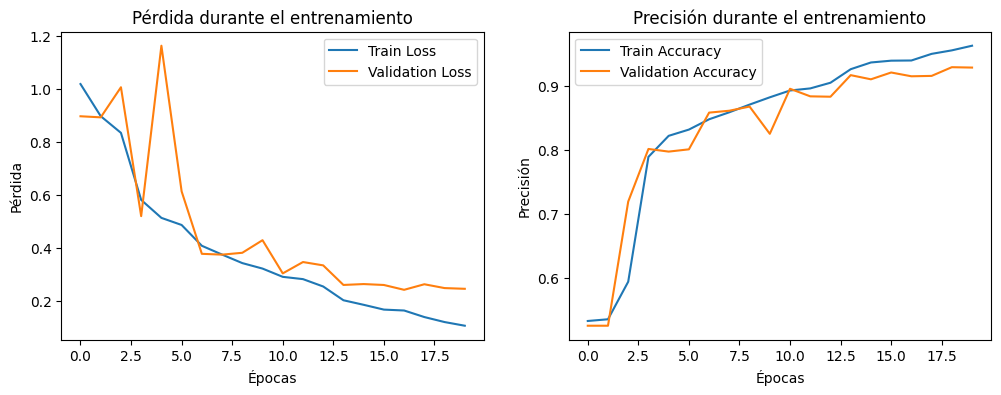

In [45]:
# Visualizar gráficos de pérdida y precisión
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de pérdida
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Pérdida durante el entrenamiento')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Pérdida')
ax1.legend()

# Gráfico de precisión
ax2.plot(history.history['accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Precisión durante el entrenamiento')
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Precisión')
ax2.legend()

print(fig)

### Conversión y Guardado del mejor Modelo en TFLite

---
Exportamos el modelo a drive en un formato .tflite ya que este formato pesa menos, puesto que a la hora de subirlo al github solo se pueden subir archivos que pesen menos de 100MB

Hemos convertido el modelo Keras `best_model8` en un modelo compatible con TensorFlow Lite (TFLite) utilizando `tf.lite.TFLiteConverter.from_keras_model()`. Esto convierte el modelo Keras en un formato que puede ser utilizado por dispositivos con recursos limitados, como dispositivos móviles o sistemas integrados.

* **Convertir el modelo a TFLite**:
  * Utilizamos `from_keras_model()` del objeto `TFLiteConverter` para convertir el modelo Keras `best_model8` en un modelo compatible con TFLite. Esto encapsula el modelo y lo prepara para ser ejecutado en dispositivos con recursos limitados.

* **Guardar el modelo TFLite en un archivo**:
  * Después de la conversión, guardamos el modelo TFLite en un archivo utilizando un objeto de archivo en modo de escritura binaria (`'wb'`). Esto nos permite almacenar el modelo en el sistema de archivos local o en la nube para su posterior uso.

* **Ruta de Guardado**:
  * El modelo TFLite se guarda en la ruta especificada `'C:/Users/admin2/Desktop/dermascan_colabs/modelos/clasificacion_malignos_3tipos_best_model8.tflite'`.

In [46]:
# Convertir el modelo en un modelo compatible con TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(best_model8)
tflite_model = converter.convert()

# Guardar el modelo TFLite en un archivo
with open('C:/Users/admin2/Desktop/dermascan_colabs/modelos/clasificacion_malignos_3tipos_best_model8.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\admin2\AppData\Local\Temp\tmp3r99mcrj\assets


INFO:tensorflow:Assets written to: C:\Users\admin2\AppData\Local\Temp\tmp3r99mcrj\assets


### Muestra de predicción de imágenes

---

* Con el conjunto de imágenes de test vamos a sacar una muestra de la predicción que ha echo el modelo vs la imagen que es realmente.

1/1 [==============================] - 0s 39ms/step


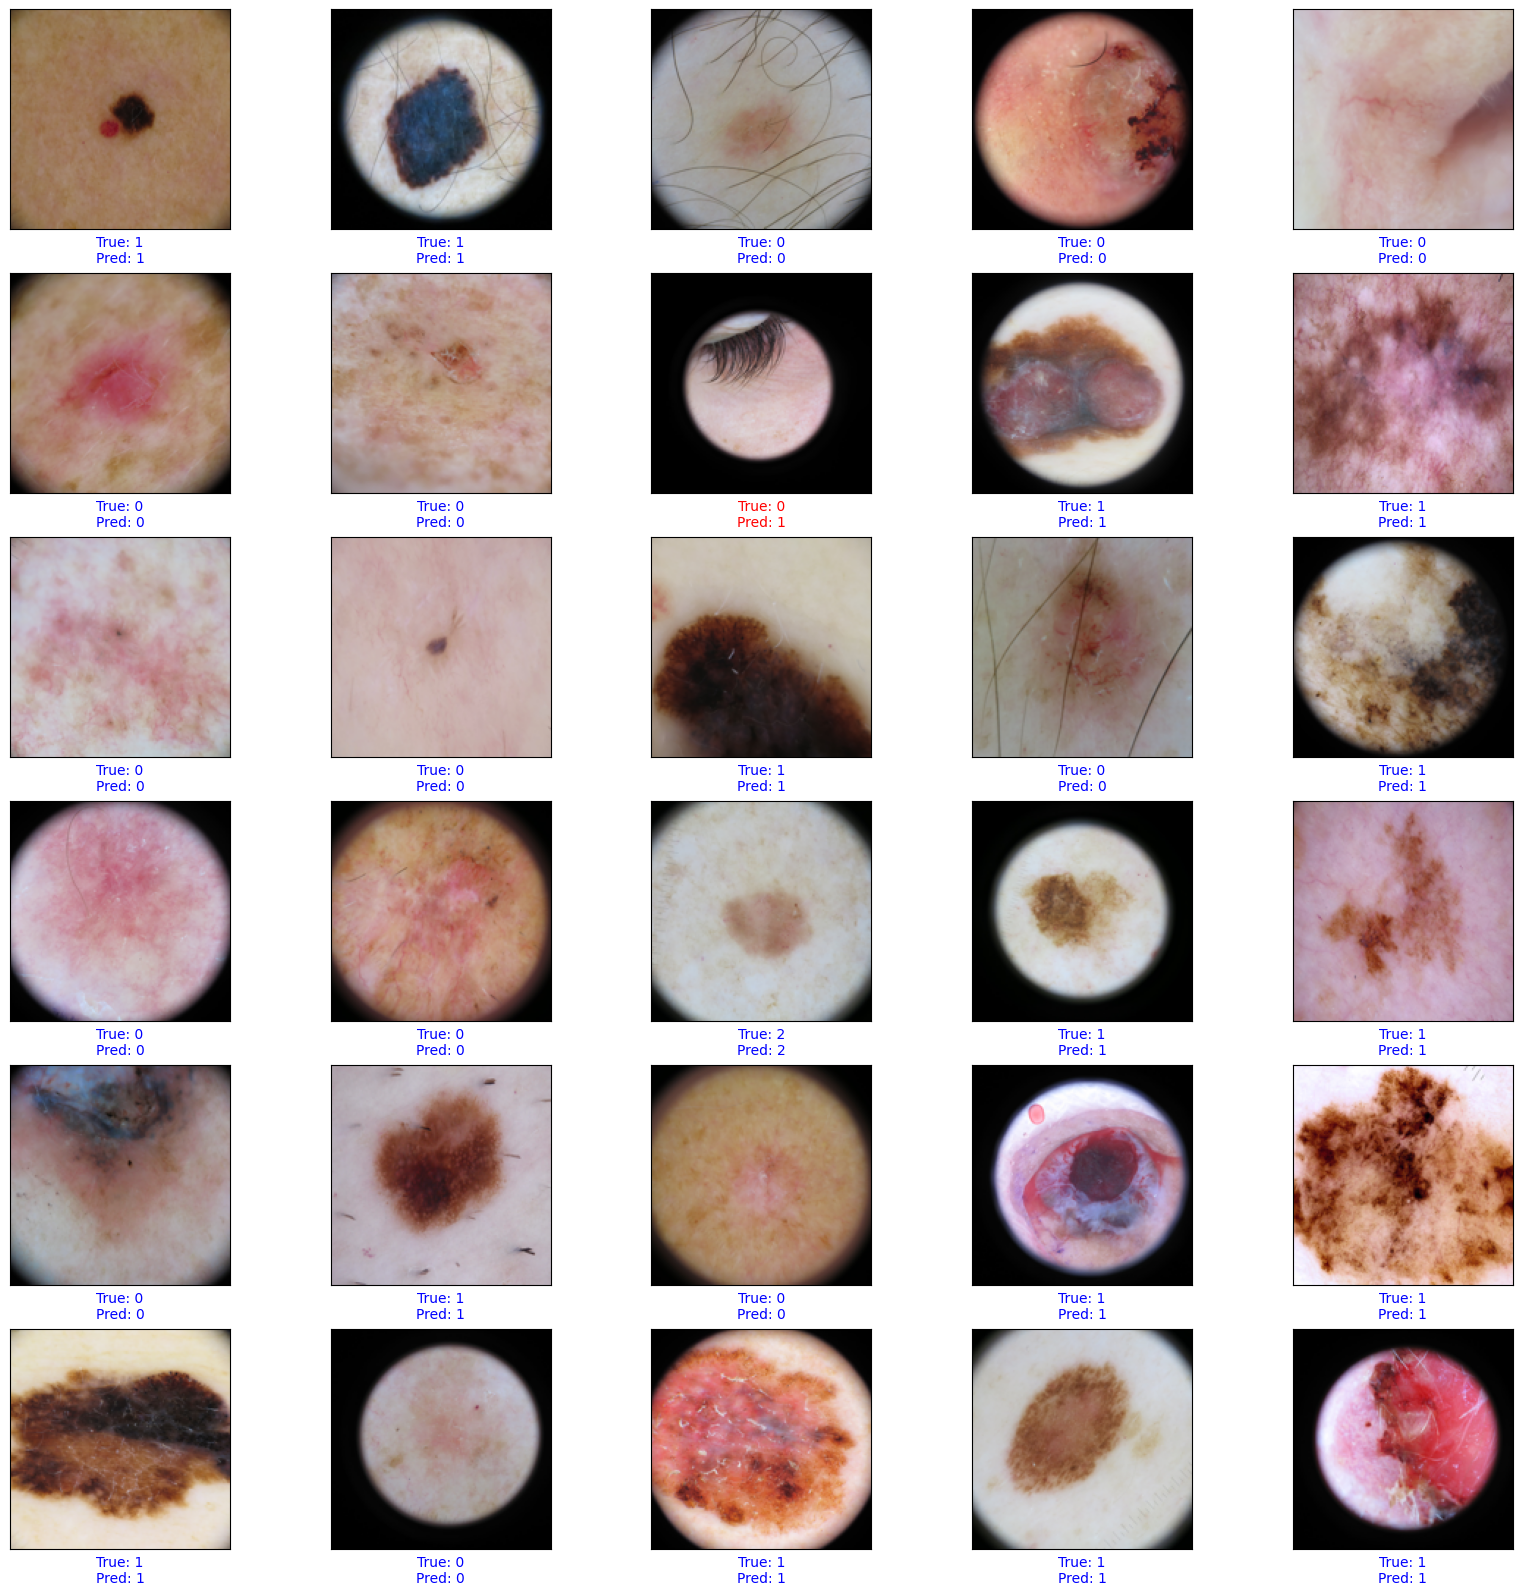

In [47]:
# Obtener el lote de imágenes y etiquetas del generador de prueba
images_batch, labels_batch = next(test_generator)

# Obtener las predicciones del modelo para el lote actual
y_pred = best_model8.predict(images_batch)

# Obtener las etiquetas predichas (índice de la clase con la probabilidad más alta)
predicted_labels = np.argmax(y_pred, axis=1)

# Obtener las etiquetas reales (índice de la clase con el valor más alto en labels_batch)
true_labels = np.argmax(labels_batch, axis=1)

# Muestra solo las imágenes bien clasificadas
plt.figure(figsize=(20, 20))
for i in range(30):
    plt.subplot(6, 5, i + 1)  # Ajusta el número de filas y columnas según sea necesario
    cmap_image = "binary" if predicted_labels[i] == true_labels[i] else "Oranges"
    plt.imshow(images_batch[i], cmap=cmap_image)
    plt.xticks([])
    plt.yticks([])
    c = "blue" if predicted_labels[i] == true_labels[i] else "red"
    plt.xlabel(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}", color=c)

plt.show()


### Predicciones erróneas

--- 

* Mostraremos algunos fallos que ha tenido el modelo

C:\Users\admin2\AppData\Local\Temp\ipykernel_636\718267723.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = best_model8.predict_generator(test_generator)


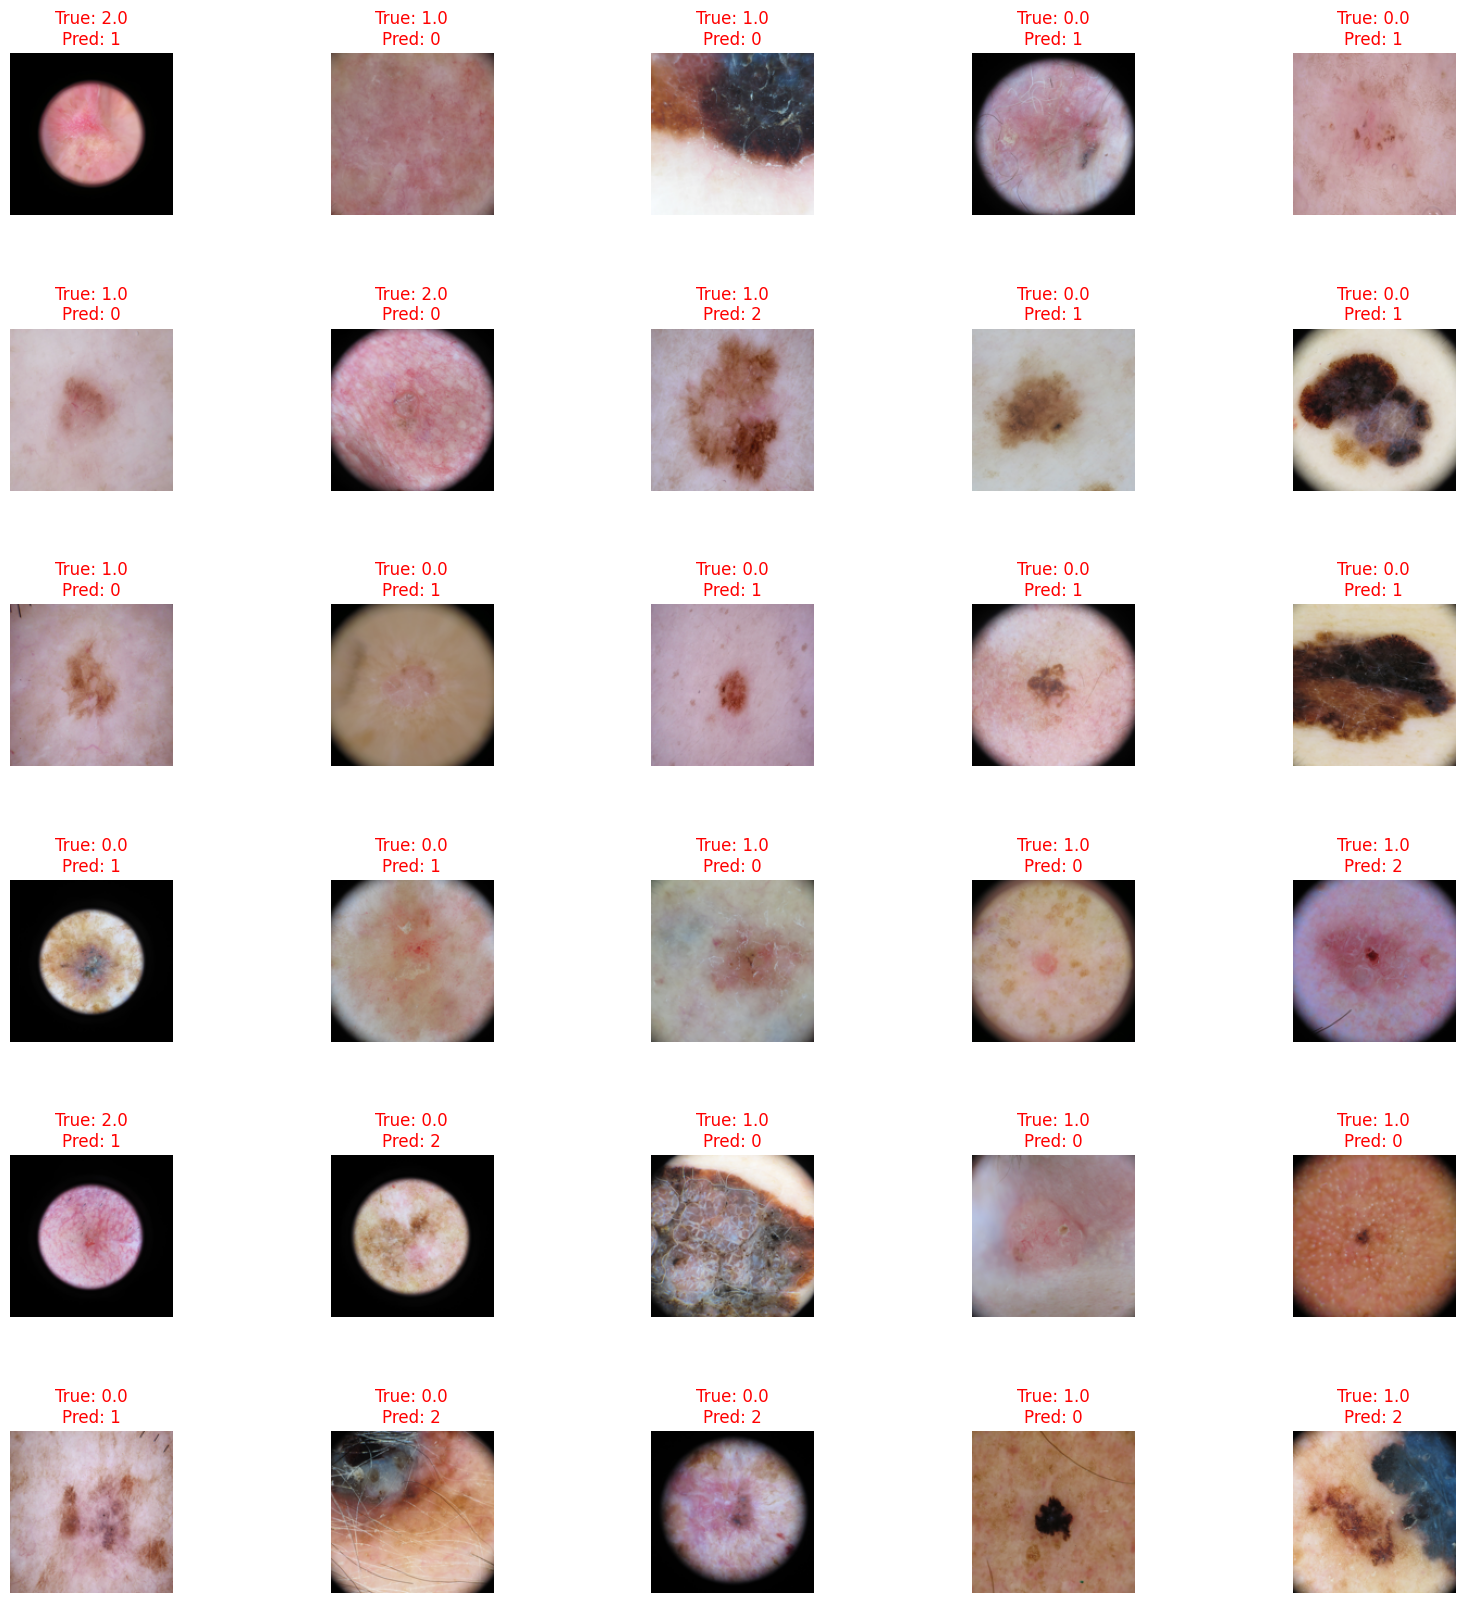

In [48]:
# Obtener las etiquetas reales del generador
y_true = y_test

# Obtener las predicciones del modelo
predictions = best_model8.predict_generator(test_generator)

# Obtener las etiquetas predichas
y_pred = predictions.argmax(axis=1)

# Obtener índices de imágenes mal clasificadas
indices_mal_clasificadas = np.where(y_true != y_pred)[0]

# Número total de imágenes mal clasificadas
total_imagenes = len(indices_mal_clasificadas)

# Establecer el número máximo de imágenes a mostrar (30 o el total de imágenes mal clasificadas, el que sea menor)
max_imagenes_mostrar = min(30, total_imagenes)

# Configurar la visualización de imágenes mal clasificadas
filas = 6
columnas = 5
plt.figure(figsize=(20, 20))

for i in range(max_imagenes_mostrar):
    images_batch, labels_batch = test_generator.next()

    imagen_mal_clasificada = images_batch[0]

    plt.subplot(filas, columnas, i + 1)
    plt.imshow(imagen_mal_clasificada)
    plt.title(f"True: {y_true[indices_mal_clasificadas[i]]}\nPred: {y_pred[indices_mal_clasificadas[i]]}", color="red")
    plt.axis('off')

plt.subplots_adjust(hspace=0.7)
plt.show()


## Prueba de predicción

### Importamos el modelo

* Extraemos nuestro modelo entrenado

In [51]:
# Ruta al archivo .tflite
ruta_archivo = 'C:/Users/admin2/Desktop/dermascan_colabs/modelos/clasificacion_malignos_3tipos_best_model8.tflite'

# Carga el modelo
best_m8 = tf.lite.Interpreter(model_path=ruta_archivo)
best_m8.allocate_tensors()

### Prueba con imagen de cáncer de piel basal_cell_carcinoma

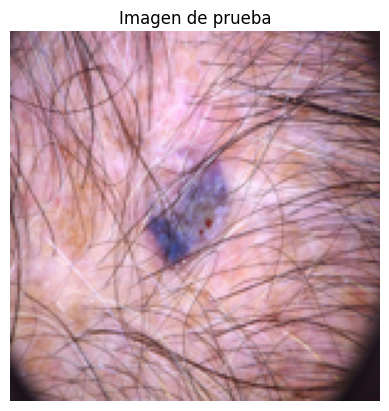

Probabilidad de clase cancer basal_cell_carcinoma: 0.99965274
Probabilidad de clase melanoma: 0.00023604967
Probabilidad de clase cancer squamous_cell_carcinoma: 0.00011120293

La imagen es cáncer de piel tipo basal_cell_carcinoma al 99.97%


In [57]:
# Cargar una imagen de prueba y redimensionarla al tamaño adecuado
imagen_prueba_path = 'C:/Users/admin2/Desktop/dermascan_colabs/imagenes_prueba/bcc_1.jpg'
imagen_prueba = Image.open(imagen_prueba_path)
imagen_prueba = imagen_prueba.resize((150, 150))  # Redimensionar la imagen al tamaño adecuado

# Mostrar la imagen
plt.imshow(imagen_prueba)
plt.title('Imagen de prueba')
plt.axis('off')  # Desactivar los ejes
plt.show()

# Convertir la imagen a un array numpy y normalizar los valores de píxeles entre 0 y 1
imagen_array = np.array(imagen_prueba, dtype=np.float32) / 255.0

# Agregar una dimensión de lote
imagen_array = np.expand_dims(imagen_array, axis=0)

# Establecer los datos de entrada
input_details = best_m8.get_input_details()
best_m8.set_tensor(input_details[0]['index'], imagen_array)

# Realizar la predicción
best_m8.invoke()

# Obtener el resultado de la predicción
prediccion = best_m8.get_tensor(best_m8.get_output_details()[0]['index'])

# Imprimir la predicción
print("Probabilidad de clase cancer basal_cell_carcinoma:", prediccion[0, 0])
print("Probabilidad de clase melanoma:", prediccion[0, 1])
print("Probabilidad de clase cancer squamous_cell_carcinoma:", prediccion[0, 2])
print("")

# Clasificación final basada en la probabilidad más alta
clase_predicha = np.argmax(prediccion)
if clase_predicha == 0:
    print(f"La imagen es cáncer de piel tipo basal_cell_carcinoma al {round(prediccion[0, 0] * 100, 2)}%")
elif clase_predicha == 1:
    print(f"La imagen es cáncer de piel tipo melanoma {round(prediccion[0, 1] * 100, 2)}%")
else:
    print(f"La imagen es cáncer de piel tipo squamous_cell_carcinoma al {round(prediccion[0, 2] * 100, 2)}%")

### Prueba con imagen de cáncer de piel melanoma

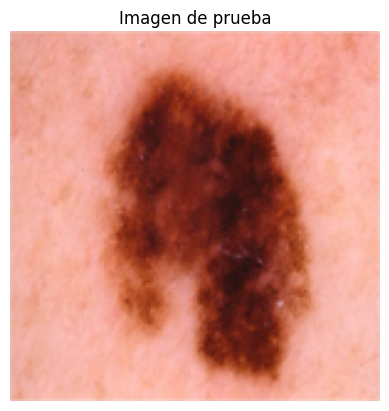

Probabilidad de clase cancer basal_cell_carcinoma: 1.2582399e-14
Probabilidad de clase melanoma: 1.0
Probabilidad de clase cancer squamous_cell_carcinoma: 9.204568e-15

La imagen es cáncer de piel tipo melanoma 100.0%


In [59]:
# Cargar una imagen de prueba y redimensionarla al tamaño adecuado
imagen_prueba_path = 'C:/Users/admin2/Desktop/dermascan_colabs/imagenes_prueba/melanoma1.jpg'
imagen_prueba = Image.open(imagen_prueba_path)
imagen_prueba = imagen_prueba.resize((150, 150))  # Redimensionar la imagen al tamaño adecuado

# Mostrar la imagen
plt.imshow(imagen_prueba)
plt.title('Imagen de prueba')
plt.axis('off')  # Desactivar los ejes
plt.show()

# Convertir la imagen a un array numpy y normalizar los valores de píxeles entre 0 y 1
imagen_array = np.array(imagen_prueba, dtype=np.float32) / 255.0

# Agregar una dimensión de lote
imagen_array = np.expand_dims(imagen_array, axis=0)

# Establecer los datos de entrada
input_details = best_m8.get_input_details()
best_m8.set_tensor(input_details[0]['index'], imagen_array)

# Realizar la predicción
best_m8.invoke()

# Obtener el resultado de la predicción
prediccion = best_m8.get_tensor(best_m8.get_output_details()[0]['index'])

# Imprimir la predicción
print("Probabilidad de clase cancer basal_cell_carcinoma:", prediccion[0, 0])
print("Probabilidad de clase melanoma:", prediccion[0, 1])
print("Probabilidad de clase cancer squamous_cell_carcinoma:", prediccion[0, 2])
print("")

# Clasificación final basada en la probabilidad más alta
clase_predicha = np.argmax(prediccion)
if clase_predicha == 0:
    print(f"La imagen es cáncer de piel tipo basal_cell_carcinoma al {round(prediccion[0, 0] * 100, 2)}%")
elif clase_predicha == 1:
    print(f"La imagen es cáncer de piel tipo melanoma {round(prediccion[0, 1] * 100, 2)}%")
else:
    print(f"La imagen es cáncer de piel tipo squamous_cell_carcinoma al {round(prediccion[0, 2] * 100, 2)}%")


### Prueba con imagen de cáncer de piel squamous_cell_carcinoma

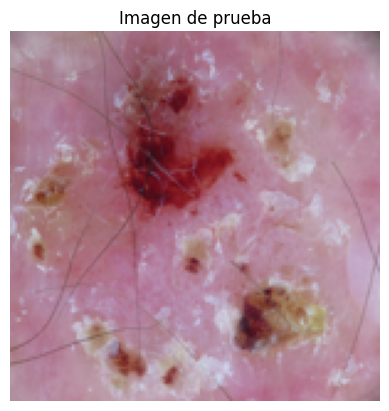

Probabilidad de clase cancer basal_cell_carcinoma: 0.00016312842
Probabilidad de clase melanoma: 2.0682173e-05
Probabilidad de clase cancer squamous_cell_carcinoma: 0.9998161

La imagen es cáncer de piel tipo squamous_cell_carcinoma al 99.98%


In [60]:
# Cargar una imagen de prueba y redimensionarla al tamaño adecuado
imagen_prueba_path = 'C:/Users/admin2/Desktop/dermascan_colabs/imagenes_prueba/scc_1.jpg'
imagen_prueba = Image.open(imagen_prueba_path)
imagen_prueba = imagen_prueba.resize((150, 150))  # Redimensionar la imagen al tamaño adecuado

# Mostrar la imagen
plt.imshow(imagen_prueba)
plt.title('Imagen de prueba')
plt.axis('off')  # Desactivar los ejes
plt.show()

# Convertir la imagen a un array numpy y normalizar los valores de píxeles entre 0 y 1
imagen_array = np.array(imagen_prueba, dtype=np.float32) / 255.0

# Agregar una dimensión de lote
imagen_array = np.expand_dims(imagen_array, axis=0)

# Establecer los datos de entrada
input_details = best_m8.get_input_details()
best_m8.set_tensor(input_details[0]['index'], imagen_array)

# Realizar la predicción
best_m8.invoke()

# Obtener el resultado de la predicción
prediccion = best_m8.get_tensor(best_m8.get_output_details()[0]['index'])

# Imprimir la predicción
print("Probabilidad de clase cancer basal_cell_carcinoma:", prediccion[0, 0])
print("Probabilidad de clase melanoma:", prediccion[0, 1])
print("Probabilidad de clase cancer squamous_cell_carcinoma:", prediccion[0, 2])
print("")

# Clasificación final basada en la probabilidad más alta
clase_predicha = np.argmax(prediccion)
if clase_predicha == 0:
    print(f"La imagen es cáncer de piel tipo basal_cell_carcinoma al {round(prediccion[0, 0] * 100, 2)}%")
elif clase_predicha == 1:
    print(f"La imagen es cáncer de piel tipo melanoma {round(prediccion[0, 1] * 100, 2)}%")
else:
    print(f"La imagen es cáncer de piel tipo squamous_cell_carcinoma al {round(prediccion[0, 2] * 100, 2)}%")

## Conclusión

---

* Hemos alcanzando un 94.45% de precisión de nuestro modelo en la clasificacion de imagenes en las categorias de cáncer de piel de 3 tipos *basal_cell_carcinoma*,  *melanoma* y *squamous_cell_carcinoma*.

* Este alto porcentaje de acierto nos asegura que muestro modelo es fiable en casi un 95% en el nivel de clasificación de tipos de cáncer de piel malignos de nuestra App.
